In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('/Users/fengzhaohong/Desktop/casestudy.csv')

In [3]:
data.head()

,Unnamed: 0,customer_email,net_revenue,year
0,0,nhknapwsbx@gmail.com,249.92,2015
1,1,joiuzbvcpn@gmail.com,87.61,2015
2,2,ukkjctepxt@gmail.com,168.38,2015
3,3,gykatilzrt@gmail.com,62.40,2015
4,4,mmsgsrtxah@gmail.com,43.08,2015


In [4]:
data = data.iloc[:,1:].copy()

In [5]:
data

,customer_email,net_revenue,year
0,nhknapwsbx@gmail.com,249.92,2015
1,joiuzbvcpn@gmail.com,87.61,2015
2,ukkjctepxt@gmail.com,168.38,2015
3,gykatilzrt@gmail.com,62.40,2015
4,mmsgsrtxah@gmail.com,43.08,2015
...,...,...,...
685922,qzqttwiftu@gmail.com,184.58,2017
685923,pjodiifjop@gmail.com,133.03,2017
685924,appaplmgko@gmail.com,200.98,2017
685925,wvkpmwsgck@gmail.com,235.35,2017


Inspect Nan Value

In [6]:
data.isnull().sum()

customer_email    0
net_revenue       0
year              0
dtype: int64

1. Calculate Total Revenue for the Current Year

In [7]:
Total_revenue_current_year=data.groupby('year')['net_revenue'].sum()

In [8]:
print('Total Revenue for the Current Year', Total_revenue_current_year)

Total Revenue for the Current Year year
2015    29036749.19
2016    25730943.59
2017    31417495.03
Name: net_revenue, dtype: float64


When assuming current year is 2017, the Total Revenue for the Current Year is 31417495.03.

When assuming current year is 2016, the Total Revenue for the Current Year is 25730943.59.

When assuming current year is 2015, the Total Revenue for the Current Year is 29036749.19.

2. Calculate New Customer Revenue 

In [13]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [14]:
df =data.copy()

In [15]:
df.to_sql('data1', con=engine)

In [18]:
engine.execute('''Select C.minyear, sum(C.net_revenue) 
From (Select A.customer_email, A.net_revenue, B.minyear 
From data1 as A Inner Join (SELECT customer_email, 
min(year) as "minyear"
FROM data1 Group by customer_email) as B 
On A.customer_email=B.customer_email AND A.year=B.minyear) as C
Group by C.minyear''').fetchall()

[(2015, 29036749.18999953),
 (2016, 18245491.010000203),
 (2017, 28676607.64000002)]

Therefore, New Customer Revenue for 2015 is 29036749.19, for 2016 is 18245491.01, for 2017 is 28676607.64

3. Existing Customer Growth 

1st calculate existing customer growth in 2016 

2nd calculate existing customer growth in 2017

In [68]:
engine.execute('''Select sum(net_revenue) 
From data1
Where year = 2016 And customer_email In (Select distinct customer_email 
From data1
Where year = 2015)''').fetchall()

[(7485452.5800000075,)]

First calculate the sum of 2016 net revenue of the customers who made purchases in 2015.

In [69]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2015 And customer_email In (Select a.customer_email 
From data1 a
Inner Join (Select customer_email From data1  Where year = 2016)as b
On a.customer_email=b.customer_email
Where a.year = 2015) ''').fetchall()

[(7465117.120000009,)]

Second calculate the sum of 2015 net revenue of the customers who also made purchases in 2016.

In [71]:
7485452.5800000075 - 7465117.120000009

20335.4599999981

Using the first result minus second result will attain the existing customer growth in 2016.

In [82]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2017 And customer_email In (Select a.customer_email 
From data1 a
Where year = 2016 Or year = 2015) ''').fetchall()

[(2740887.3900000127,)]

First calcutate the sum of 2017 net reveune of customers who made purchases in 2016 or 2015.

In [80]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2016 And customer_email In (Select a.customer_email 
From data1 a
Inner Join (Select customer_email From data1  Where year = 2017)as b
On a.customer_email=b.customer_email
Where a.year = 2016) ''').fetchall()

[(2620648.6499999906,)]

Second calculte the sum of 2016 net revenue of customers who made purchases in 2017.

In [83]:
2740887.390000012 - 2620648.6499999906

120238.74000002118

The gap between these two result will be the existing customer growth in 2017.

The Existing Customer Growth in 2016 is 20335.46.

The Existing Customer Growth is 2017 is 120238.74.

4. Revenue lost from attrition

In [17]:
engine.execute('''Select sum(A.net_revenue)
From data1 as A 
Where A.year = 2016 And A.customer_email In (Select customer_email 
From data1 
Where year = 2015)''').fetchall()

[(7485452.5800000075,)]

Calculate the sum of net revenue (in 2016) of the customers who had made purchased in 2015.  

In [14]:
engine.execute('''Select sum(A.net_revenue)
From data1 as A 
Where A.year = 2015 ''').fetchall()

[(29036749.18999953,)]

Calculate the original sum of net revenue of the customers in 2015.

In [96]:
7485452.5800000075-29036749.18999953

-21551296.609999523

Using the first calculation result minus the second result would be the revenue lost from attrition in 2016. 

In [13]:
engine.execute('''Select sum(A.net_revenue)
From data1 as A 
Where A.year = 2017 And A.customer_email In (Select distinct customer_email 
From data1 
Where year = 2016)''').fetchall()

[(2641259.990000008,)]

First calculate the sum of net revenue (in 2017) of the customers who had made purchases in 2016.

In [14]:
engine.execute('''Select sum(net_revenue)
From data1  
Where year = 2016''').fetchall()

[(25730943.58999988,)]

Second calculate the sum of net revenue of customers who had made purchases in 2016.

In [15]:
2641259.990000008-25730943.58999988

-23089683.59999987

Using the first calculation result minus the second one will be the revenue lost from attrition in 2017.

For 2016 Revenue lost from attrition is 21551296.61

For 2017 Revenue lost from attrition is 23089683.60

5 & 6 Existing Customer Revenue Current Year and Existing Customer Revenue Prior Year

In [16]:
engine.execute('''Select sum(net_revenue) 
From data1
Where year = 2016 And customer_email In (Select distinct customer_email 
From data1
Where year = 2015)''').fetchall()

[(7485452.5800000075,)]

In [17]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2015 And customer_email In (Select a.customer_email 
From data1 a
Inner Join (Select customer_email From data1  Where year = 2016)as b
On a.customer_email=b.customer_email
Where a.year = 2015) ''').fetchall()

[(7465117.120000009,)]

In [18]:
engine.execute('''Select sum(net_revenue)
From data1
Where year = 2017 And customer_email In (Select distinct customer_email
From data1
Where year = 2016 Or year = 2015)''').fetchall()

[(2740887.3900000127,)]

In [19]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2016 And customer_email In (Select a.customer_email 
From data1 a
Inner Join (Select customer_email From data1  Where year = 2017)as b
On a.customer_email=b.customer_email
Where a.year = 2016) ''').fetchall()

[(2620648.6499999906,)]

When assuming 2015 is the current year, since it is the first year of the data, there is no Existing Customer for Revenue Current Year or Existing Customer Revenue for Prior Year.

When assuming 2016 is the current year, the Existing Customer Revenue for Current Year is 7485452.58, the Existing Customer Revenue for Prior Year is 7465117.12 

When assuming 2017 is the current year, the Existing Customer Revenue for Current Year is 2740887.39, the Existing Customer Revenue for Prior Year is 2620648.65.

7 & 8 . Total Customers Current Year and Total Customers Previous Year

In [21]:
engine.execute('''Select year, 
count(distinct customer_email)
From data1 
Group by year''').fetchall()

[(2015, 231294), (2016, 204646), (2017, 249987)]

In [73]:
engine.execute('''Select 
count(distinct customer_email)
From data1 
Where year = 2016 Or year =2015''').fetchall()

[(376356,)]

When assuming current year is 2017, there are 249987 customers in current year. There are 204646 customers in 2016, and 376356 customers totally for pervious years.

When assuming current year is 2016, there are 204646 customers in current year. There are 231294 customers for pervious year.

When assuming current year is 2015, there are 231294 customers in current year. There are 0 customer for pervious year.

9. New Customers

In [32]:
engine.execute('''Select count(distinct customer_email)
From data1 
Where year = 2015 ''').fetchall()

[(231294,)]

In [31]:
engine.execute('''Select count(distinct customer_email)
From data1 
Where year = 2016 And customer_email Not In (Select distinct customer_email 
From data1
Where year = 2015)''').fetchall()

[(145062,)]

In [93]:
engine.execute('''Select count(distinct customer_email)
From data1 
Where year = 2017 And customer_email Not In (Select distinct customer_email 
From data1
Where year = 2016 Or year = 2015)''').fetchall()

[(228262,)]

New Customers for 2017 is 228262

New Customers for 2016 is 145062

New Customers for 2015 is 231294

10.Lost Customers

In [42]:
engine.execute('''Select count(distinct customer_email)
From data1 
Where year = 2015 And customer_email Not In (Select distinct customer_email 
From data1
Where year = 2016 )''').fetchall()

[(171710,)]

In [41]:
engine.execute('''Select count(distinct customer_email)
From data1
Where (year = 2016) And customer_email Not In(Select distinct customer_email
From data1
Where year = 2017) ''').fetchall()

[(183687,)]

In [46]:
engine.execute('''Select count(distinct customer_email)
From data1
Where (year = 2015 Or year = 2016) And customer_email Not In(Select distinct customer_email
From data1
Where year = 2017)''').fetchall()

[(354631,)]

The lost customers for 2016 is 171710.

The lost customers for 2017 is 183687.

The total lost customer for 2017 since 2015 is 354631.

Visualizations

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot 1 Ratio of Existing Customer Revenue Current Year to Total Customers Current Year

In [20]:
7485452.58/25730943.59, 

(0.29091247873665715,)

For 2016 ratio

In [21]:
2740887.39/31417495.03

0.08724079966855333

For 2017 ratio

Text(0.5, 1.0, 'Ratio of Existing Customer Revenue Current Year to Total Customers Current Year')

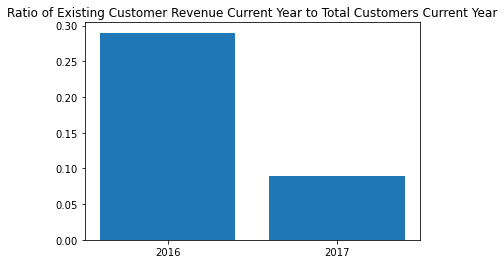

In [22]:
ratio = [0.29,0.09]
year = ['2016','2017']
plt.bar(year,ratio)
plt.title('Ratio of Existing Customer Revenue Current Year to Total Customers Current Year')

As we see, the ratio decreased in 2017.

Plot 2 New customer ratio.

Text(0.5, 1.0, 'Ratio of New Customers Each Year')

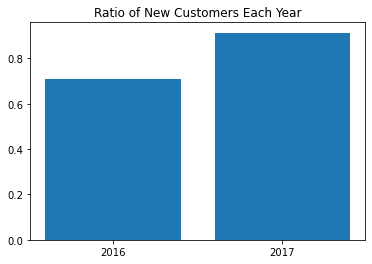

In [24]:
new_ratio_2016 = 145062/204646
new_ratio_2017 = 228262/249987
new_ratio = [new_ratio_2016,new_ratio_2017]
plt.bar(year,new_ratio)
plt.title('Ratio of New Customers Each Year')

The new customer ratio increase in 2017.

Plot 3 We can also investigate the net revenue for each customer who had purchased from 2015 all the way to 2017(loyal customer),
discover their net revenue changes.

In [27]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2017 And customer_email In (Select a.customer_email 
From data1 a
Inner Join (Select distinct customer_email from data1 Where year=2015) as b 
On a.customer_email = b.customer_email 
Where year = 2016) ''').fetchall()

[(764387.7299999989,)]

In [29]:
engine.execute('''Select sum(net_revenue)
From data1 
Where year = 2016 And customer_email In (Select distinct a.customer_email 
From data1 a
Where a.year = 2015) ''').fetchall()

[(7485452.5800000075,)]

In [30]:
engine.execute('''Select count(distinct customer_email)
From data1 
Where year = 2017 And customer_email In (Select a.customer_email 
From data1 a
Inner Join (Select distinct customer_email from data1 Where year=2015) as b 
On a.customer_email = b.customer_email 
Where year = 2016) ''').fetchall()

[(6162,)]

In [31]:
engine.execute('''Select count(distinct customer_email)
From data1 
Where year = 2016 And customer_email In (Select distinct a.customer_email 
From data1 a
Where a.year = 2015) ''').fetchall()

[(59584,)]

Text(0.5, 1.0, 'Per Loyal Customer Net Revenue')

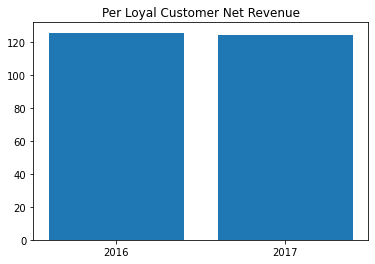

In [32]:
loyal_2017 = 764387.73/6162
loyal_2016 = 7485452.58/59584
loyal_per_revenue = [loyal_2016,loyal_2017]
plt.bar(year,loyal_per_revenue)
plt.title('Per Loyal Customer Net Revenue')

As we see, for the "loyal customer", their net revenue has not changed too much for each year (which is around 120 on average). 